<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3.6-LSTMB-200k-adasyn-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (Balanced Weights)

LSTM is generally doing the best out of our deep learning models.

We saw an improvement when we under sampled, however, this cut down our 1 million samples to about 500k.

In this notebook we will try synthetic upsampling using ADASYN where samples will be created near borders of various classes to see if this improves our model.

We will start with sample set that has 200k samples like most of our deep learning model runs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import importlib


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru
import util.metric_util as mu



logging.basicConfig(level=logging.INFO)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


DEBUG = False
RSTATE=1
N_JOBS=5


MODEL_NAME = "LSTMB"
LSTM_DIM = 64 # total LSTM units
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units and 20% 1D Spatial Dropout - Balanced Weights - ADASYN"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 8

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  sampler = ADASYN(random_state=RSTATE, sampling_strategy='not majority', n_jobs = N_JOBS, n_neighbors = 2)
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"
  sampler = ADASYN(random_state=RSTATE, sampling_strategy='not majority', n_jobs = N_JOBS)


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[FEATURE_COLUMN]



# Preprocessing

In [4]:

import importlib
importlib.reload(ku)

X_train, X_test, y_train, y_test, t = ku.preprocess_file(df, 
                                                      FEATURE_COLUMN, 
                                                      LABEL_COLUMN,
                                                      report_dir = f'{DRIVE_DIR}/reports',
                                                      use_oov_token = True,
                                                      sampler = sampler,
                                                      )


Vocabulary size=52524
Number of Documents=199134
Splitting data into training and test sets...
Training X type <class 'numpy.ndarray'> y type <class 'pandas.core.series.Series'>
Training X shape (149350, 100) y shape (149350,)
Test X shape (49784, 100) y shape (49784,)
Start sampling with ADASYN
Resampled X type <class 'numpy.ndarray'> y type <class 'numpy.ndarray'>
Resampled X shape (397008, 100) y shape (397008,)
Resampled distribution:
   index
0       
1  77555
2  80630
3  74874
4  83739
5  80210
Shape of y_train (397008, 1)
One hot enocde label data...


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts) + 1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15757500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 15,851,265
Trainable params: 15,851,265
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')



mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.43633872 3.07851898 2.18840596 1.19528211 0.3723871 ]
Number of training examples: 397008
Train on 317606 samples, validate on 79402 samples
Epoch 1/50
317606/317606 [==============================] - 876s 3ms/sample - loss: 1.1560 - categorical_accuracy: 0.4837 - val_loss: 4.6453 - val_categorical_accuracy: 0.0091
Epoch 2/50
317606/317606 [==============================] - 872s 3ms/sample - loss: 1.0173 - categorical_accuracy: 0.5352 - val_loss: 4.7773 - val_categorical_accuracy: 0.0133
Epoch 3/50
317606/317606 [==============================] - 879s 3ms/sample - loss: 0.9626 - categorical_accuracy: 0.5596 - val_loss: 5.1987 - val_categorical_accuracy: 0.0213
Epoch 00003: early stopping


Number of test: 49784
Running model.evaluate...
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

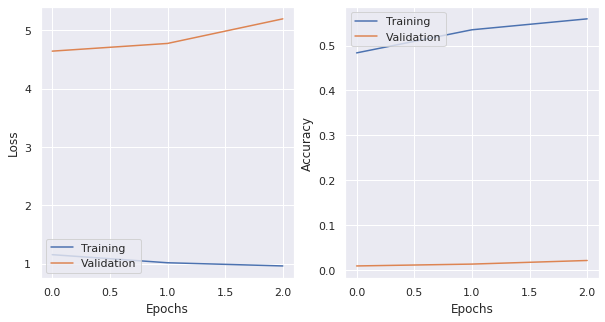


Confusion Matrix
[[ 5355   570   447   232   377]
 [ 1464   467   581   421   292]
 [  835   449  1071  1300   885]
 [  293   242   606  2810  4347]
 [  500   371   455  1866 23548]]

Classification Report
              precision    recall  f1-score   support

           1       0.63      0.77      0.69      6981
           2       0.22      0.14      0.18      3225
           3       0.34      0.24      0.28      4540
           4       0.42      0.34      0.38      8298
           5       0.80      0.88      0.84     26740

    accuracy                           0.67     49784
   macro avg       0.48      0.47      0.47     49784
weighted avg       0.63      0.67      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

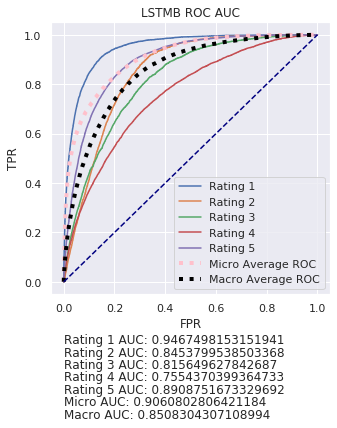

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

INFO:util.report_util:calculating metric from dictionary
INFO:util.report_util:got all values to calculate


Score: 0.3002629445706049


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB-1x64-random_embedding-sampling_none-446792-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-446792-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-446792-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB-1x64-random_embedding-sampling_none-446792-100-star_rating-weights.h5


INFO:root:Saving tokenizer file: drive/My Drive/Springboard/capstone/models/dl-tokenizer.pkl


Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'LSTMB', 'architecture': '1x64', 'description': '1 Layer 64 LSTM Units and 20% 1D Spatial Dropout - Balanced Weights - ADASYN', 'classification_report': '{"1": {"precision": 0.6339528826802415, "recall": 0.7670820799312419, "f1-score": 0.6941923774954627, "support": 6981}, "2": {"precision": 0.22248689852310624, "recall": 0.1448062015503876, "f1-score": 0.17543200601051842, "support": 3225}, "3": {"precision": 0.33892405063291137, "recall": 0.23590308370044052, "f1-score": 0.2781818181818182, "support": 4540}, "4": {"precision": 0.4238950067883542, "recall": 0.3386358158592432, "f1-score": 0.3764989616131842, "support": 8298}, "5": {"precision": 0.7996196814832423, "recall": 0.8806282722513089, "f1-score": 0.8381711722935093, "support": 26740}, "accuracy": 0.6679053511168247, "

In [11]:
print(datetime.now())

2019-11-10 05:10:51.894602
